# 26.2.3 Relax Inc. Take-Home Challenge

# Import Modules and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# random forest
from sklearn.ensemble import RandomForestClassifier

#skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real

#sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#XGBoost
from xgboost import XGBClassifier

# SHAP
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Open the file in binary mode to inspect raw bytes
with open('../data/takehome_users.csv', 'rb') as file:
    content = file.read()  # Read the entire file in binary mode

# Locate the problematic byte
try:
    content.decode('utf-8')
except UnicodeDecodeError as e:
    print(f"Error: {e}")  # This will show the byte position of the error
    error_position = e.start

    # Display the problematic byte and surrounding context
    surrounding_bytes = content[error_position-3:error_position+3]  # Adjust range as needed
    print(f"Problematic byte sequence: {surrounding_bytes}")

I found a non utf-8 character in the users.csv file and removed it using the following above code. I then saved a corrected version, which I am pulling the data from below. 

In [2]:
users_df = pd.read_csv('../data/takehome_users_corrected.csv')
engagement_df = pd.read_csv('../data/takehome_user_engagement.csv')

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Defining an 'adopted' user

I could use a join to attach the engagement data to the user data using ID. But that seems like overkill if all that needs to happen is determine which users are 'adopted' users. 

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven ­day period

In [6]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Looks like all the data is there but the time stamp is not in datetime format. 

In [7]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])


In [8]:
#identify users that have 3 or more engagements in the data. 

users_3plus_engagements = []

for id in engagement_df['user_id'].unique():
    if len(engagement_df[engagement_df['user_id']==id]) >= 3:
        users_3plus_engagements.append(id)


print(f'There are {len(users_3plus_engagements)} users with 3 or more engagements out of a total of {len(engagement_df)} records.')
    

There are 2248 users with 3 or more engagements out of a total of 207917 records.


In [9]:
approved_ids = []
# Create a DataFrame with user engagement data filtered for the specified user IDs
filtered_data = engagement_df[engagement_df['user_id'].isin(users_3plus_engagements)]


# Set the time_stamp as the index
filtered_data.set_index('time_stamp', inplace=True)

# Calculate the 7-day rolling count of 'visited' for all users in one go
filtered_data['7_day_engagement'] = filtered_data.groupby('user_id')['visited'].rolling(window='7D').count().reset_index(level=0, drop=True)

# Identify approved user IDs where the 7-day engagement is 3 or more
approved_ids = filtered_data[filtered_data['7_day_engagement'] >= 3]['user_id'].unique().tolist()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Add class label to user data

In [10]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
users_df['adopted_user'] = users_df['object_id'].isin(approved_ids).astype(int)


In [13]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [14]:
duplicates = users_df.duplicated()
print(duplicates.unique())

[False]


Looks like none of the users are duplicated

In [15]:
users_df['adopted_user'].value_counts()

adopted_user
0    10398
1     1602
Name: count, dtype: int64

The classes for adopted users are defined now, so I can moe forward with EDA and modeling. 
I do see a class imbalance. Only about 15% of the records are adopted users. 
That might be important moving forward. 

# EDA

In [16]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Two columns with missing values here. 'last_session_creation_time' and 'invited_by_user_id'.

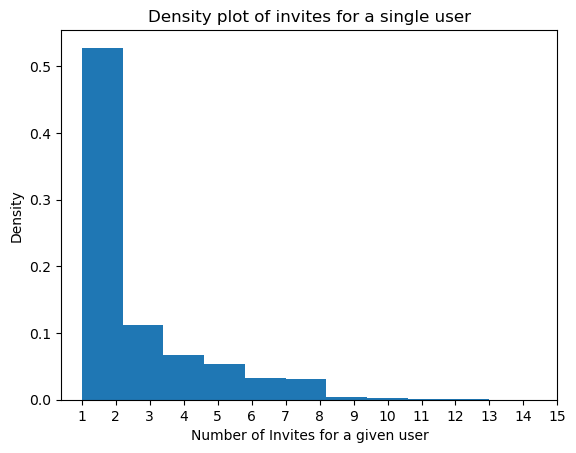

In [17]:
# Are there any user ID's that are inviting the majority of the users, such that the actual user doing the invites might be important. 
users_df['invited_by_user_id'].value_counts().hist(density = True)

plt.xlabel("Number of Invites for a given user")
plt.ylabel("Density")
plt.xticks(ticks = range(1,16))
plt.title("Density plot of invites for a single user")

plt.grid(False)
plt.show()

Most users who have invited someone only seem to have invited one or two other people. There isn't one user who is inviting a ton of people
and personally driving engagement. The fact that a user has been invited is already captued in the creation source feature. I think
it's safe to drop the 'invited_by_user_id' feature to eliminate the missing values

In [18]:
users_df.drop(columns = 'invited_by_user_id', inplace = True)

In [19]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   adopted_user                12000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 937.6+ KB


The remaining missing values are from the 'last_session_creation_time' column. This is a column of unix timestamps for the last login. 
I'm interpreting these missing values to mean that there was no recent log in, as in the account was created and never used. 
I want to see if there are any patterns in the users with null values here. Specifically, do they have a specific creation source in common. 

In [20]:
no_last_session_df = users_df[users_df['last_session_creation_time'].isna()]
no_last_session_df['creation_source'].value_counts()

creation_source
PERSONAL_PROJECTS    1347
ORG_INVITE           1066
GUEST_INVITE          575
SIGNUP                189
Name: count, dtype: int64

Not much here, a lot of these coule be personal accounts that were never used, but there sould also be a lot of people who
were getting org invites but had no need for the product in their work at the org. These are basically bounced users in some sense. 
To get around the null values in the column for last session, I'm going to create a couple new columns to capture the info. 

In [21]:
# convert unix timestamps and cratiion_time column to datetime objects
users_df['last_session_creation_timestamp'] = pd.to_datetime(users_df['last_session_creation_time'], unit = 's')
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

In [22]:
#does the creation time stamp and the last session creation time_stamp match for any rows? 
matching_timestamps = users_df[users_df['last_session_creation_timestamp']==users_df['creation_time']]
print(f'Of the users that have a non-null last session creation data, there are {len(matching_timestamps)} users where the creation data and last session date are the same.')

Of the users that have a non-null last session creation data, there are 3027 users where the creation data and last session date are the same.


This indicates that the missing values in this column are actually missing values, not users who never logged in again after creating their account as I originally surmised. 
If the last login date is really missing, there is no way to impute it, it could be anything. That being said, is it possible that the last login data could be gathered from the 
engagement dataframe? 


In [23]:

# List of user IDs to check
user_ids_to_check = no_last_session_df['object_id'].unique().tolist()

# Check if any of the user IDs are in the 'user_id' column
found_ids = engagement_df['user_id'][engagement_df['user_id'].isin(user_ids_to_check)]

if not found_ids.empty:
    print(f'Found user IDs: {found_ids.tolist()}')
else:
    print('No user IDs found in the DataFrame.')


No user IDs found in the DataFrame.


Looks like the IDs with missing values for last_login are not found in the engagement_df either. 
I can either drop the last login date column, or drop all the rows with missing values for this column.
There are risks either way. If I drop the column, I'm losing a feature, and if I drop the rows, I lose a good portion of my user data. 

That being said, some of the user login behavior is already captured in the 'adopted_user' column. The positive class there is not defined by
the last log in, but rather by logging in on at least 3 days in a seven day period. 

The last login column also has limited utility in the sense that thousands of rows in the column just reflect the creation date.
That tells us that the user is not an adopted user, which could cause data leakage if the column is kept as a feature. 

I'm just going to remove the column and keep the user info. 


In [24]:
#users_df.drop(columns= ['last_session_creation_time','last_session_creation_timestamp'], inplace = True)
users_df.dropna(subset = ['last_session_creation_time'], inplace=True)

In [25]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   object_id                        8823 non-null   int64         
 1   creation_time                    8823 non-null   datetime64[ns]
 2   name                             8823 non-null   object        
 3   email                            8823 non-null   object        
 4   creation_source                  8823 non-null   object        
 5   last_session_creation_time       8823 non-null   float64       
 6   opted_in_to_mailing_list         8823 non-null   int64         
 7   enabled_for_marketing_drip       8823 non-null   int64         
 8   org_id                           8823 non-null   int64         
 9   adopted_user                     8823 non-null   int64         
 10  last_session_creation_timestamp  8823 non-null   datetime64[ns]


No more null values. I can drop the name and email info as well, since it's redundant with the user_id captured in object id and it's all personal 
identifying info. I'll keep objectID for now. I can drop it later for modeling if needed.

In [26]:
# Can drop name and email - They are redundant with ID
users_df.drop(columns= ['name','email'], inplace = True)

In [27]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8823 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   object_id                        8823 non-null   int64         
 1   creation_time                    8823 non-null   datetime64[ns]
 2   creation_source                  8823 non-null   object        
 3   last_session_creation_time       8823 non-null   float64       
 4   opted_in_to_mailing_list         8823 non-null   int64         
 5   enabled_for_marketing_drip       8823 non-null   int64         
 6   org_id                           8823 non-null   int64         
 7   adopted_user                     8823 non-null   int64         
 8   last_session_creation_timestamp  8823 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 689.3+ KB


## Create feature for time on platform

In [28]:
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,last_session_creation_timestamp
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,1,2014-03-31 03:45:04
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,0,2013-01-22 10:14:20


In [29]:
users_df['time_between_creation_and_last_login'] = users_df['last_session_creation_timestamp'] - users_df['creation_time']
users_df['time_between_creation_and_last_login'] = users_df['time_between_creation_and_last_login'].dt.days.astype(int)

users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8823 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   object_id                             8823 non-null   int64         
 1   creation_time                         8823 non-null   datetime64[ns]
 2   creation_source                       8823 non-null   object        
 3   last_session_creation_time            8823 non-null   float64       
 4   opted_in_to_mailing_list              8823 non-null   int64         
 5   enabled_for_marketing_drip            8823 non-null   int64         
 6   org_id                                8823 non-null   int64         
 7   adopted_user                          8823 non-null   int64         
 8   last_session_creation_timestamp       8823 non-null   datetime64[ns]
 9   time_between_creation_and_last_login  8823 non-null   int64         
dtypes: d

In [30]:
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,last_session_creation_timestamp,time_between_creation_and_last_login
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,0,2014-04-22 03:53:30,0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,1,2014-03-31 03:45:04,136
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,0,2013-03-19 23:14:52,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,0,2013-05-22 08:09:28,1
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,0,2013-01-22 10:14:20,5


# Feature Comparisons

In [31]:
adopted_df = users_df[users_df['adopted_user']==1]
not_adopted_df = users_df[users_df['adopted_user']==0]

### Opted into mailing list

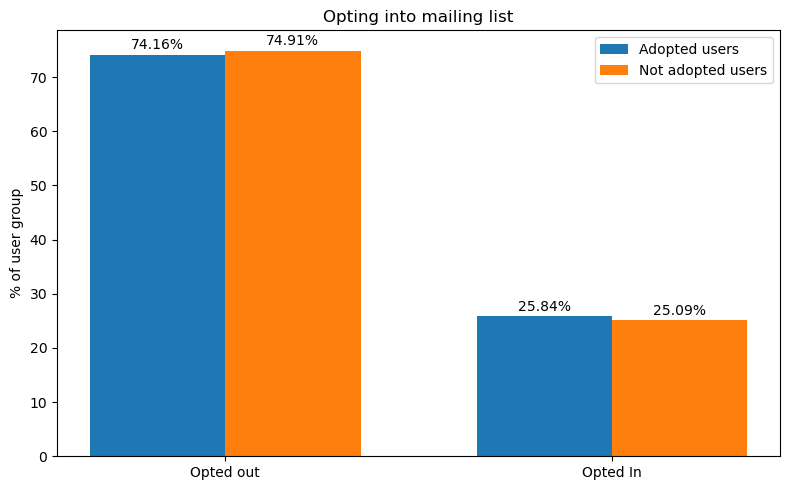

In [41]:
percentages_adopted = adopted_df['opted_in_to_mailing_list'].value_counts(normalize=True) * 100
percentages_not_adopted = not_adopted_df['opted_in_to_mailing_list'].value_counts(normalize=True) * 100

# Create a side-by-side bar chart
labels = ['Opted out', 'Opted In']  # Labels for the binary values
bar_width = 0.35     # Width of the bars
x = range(len(labels))  # X positions for the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Create bars for each column
bars1 = ax.bar(x, percentages_adopted, width=bar_width, label='Adopted users', color='Tab:blue')
bars2 = ax.bar([p + bar_width for p in x], percentages_not_adopted, width=bar_width, label='Not adopted users', color='Tab:orange')

# Add title and labels
ax.set_title('Opting into mailing list')
#ax.set_xlabel('Binary Values')
ax.set_ylabel('% of user group')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)

# Add legend
ax.legend()

# Show the percentages on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

### Enabled for marketing drip

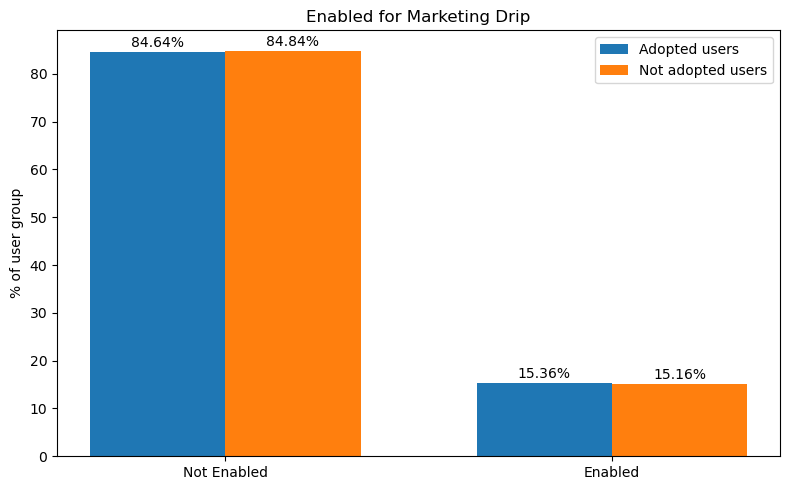

In [40]:
percentages_adopted = adopted_df['enabled_for_marketing_drip'].value_counts(normalize=True) * 100
percentages_not_adopted = not_adopted_df['enabled_for_marketing_drip'].value_counts(normalize=True) * 100

# Create a side-by-side bar chart
labels = ['Not Enabled', 'Enabled']  # Labels for the binary values
bar_width = 0.35     # Width of the bars
x = range(len(labels))  # X positions for the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Create bars for each column
bars1 = ax.bar(x, percentages_adopted, width=bar_width, label='Adopted users', color='Tab:Blue')
bars2 = ax.bar([p + bar_width for p in x], percentages_not_adopted, width=bar_width, label='Not adopted users', color='Tab:orange')

# Add title and labels
ax.set_title('Enabled for Marketing Drip')
#ax.set_xlabel('Binary Values')
ax.set_ylabel('% of user group')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)

# Add legend
ax.legend()

# Show the percentages on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

### Creation Source

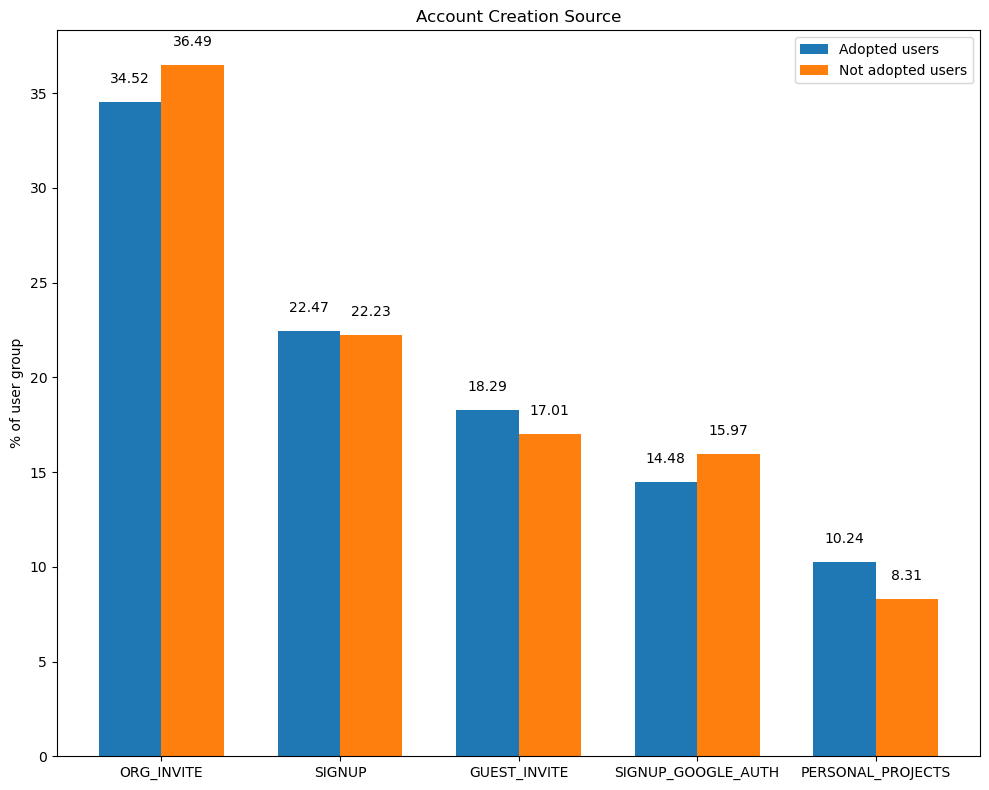

In [44]:
adopted_creation_source = adopted_df['creation_source'].value_counts(normalize=True) * 100
adopted_creation_source_list = adopted_creation_source.tolist()
adopted_creation_source_list

not_adopted_creation_source = not_adopted_df['creation_source'].value_counts(normalize=True) * 100
not_adopted_creation_source_list = not_adopted_creation_source.tolist()
not_adopted_creation_source_list

# Create a side-by-side bar chart
labels = adopted_df['creation_source'].unique().tolist()  # Labels for the binary values
bar_width = 0.35     # Width of the bars
x = range(len(labels))  # X positions for the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create bars for each column
bars1 = ax.bar(x, adopted_creation_source_list, width=bar_width, label='Adopted users', color='Tab:blue')
bars2 = ax.bar([p + bar_width for p in x], not_adopted_creation_source_list, width=bar_width, label='Not adopted users', color='Tab:orange')

# Add title and labels
ax.set_title('Account Creation Source')
#ax.set_xlabel('Account Creation Source')
ax.set_ylabel('% of user group')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)

# Add legend
ax.legend()

# Show the percentages on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

### Org ID

In [45]:
print(f"There are {len(adopted_df['org_id'].unique())} unique organizations for the adopted users")
print(f"There are {len(not_adopted_df['org_id'].unique())} unique organizations for the non-adopted users")

There are 400 unique organizations for the adopted users
There are 417 unique organizations for the non-adopted users


In [47]:
organizations_list = []
adopted_percentages_list = []
not_adopted_percentages_list = []

for org in users_df['org_id'].value_counts().head(10).index:

    total_org_users = len(users_df[users_df['org_id']== org])
    adopted_org_users = len(adopted_df[adopted_df['org_id']== org]) # Number of adopted users for this org
    non_adopted_org_users = len(not_adopted_df[not_adopted_df['org_id']== org]) # Number of not adopted users for this org
    adopted_users_percent = (adopted_org_users/ len(adopted_df))*100 # % of all adopted users associated with this org
    non_adopted_users_percent = (non_adopted_org_users/ len(not_adopted_df))*100  # % of all not_adopted users associated with this org
    



    organizations_list.append(str(org))
    adopted_percentages_list.append(adopted_users_percent)
    not_adopted_percentages_list.append(non_adopted_users_percent)

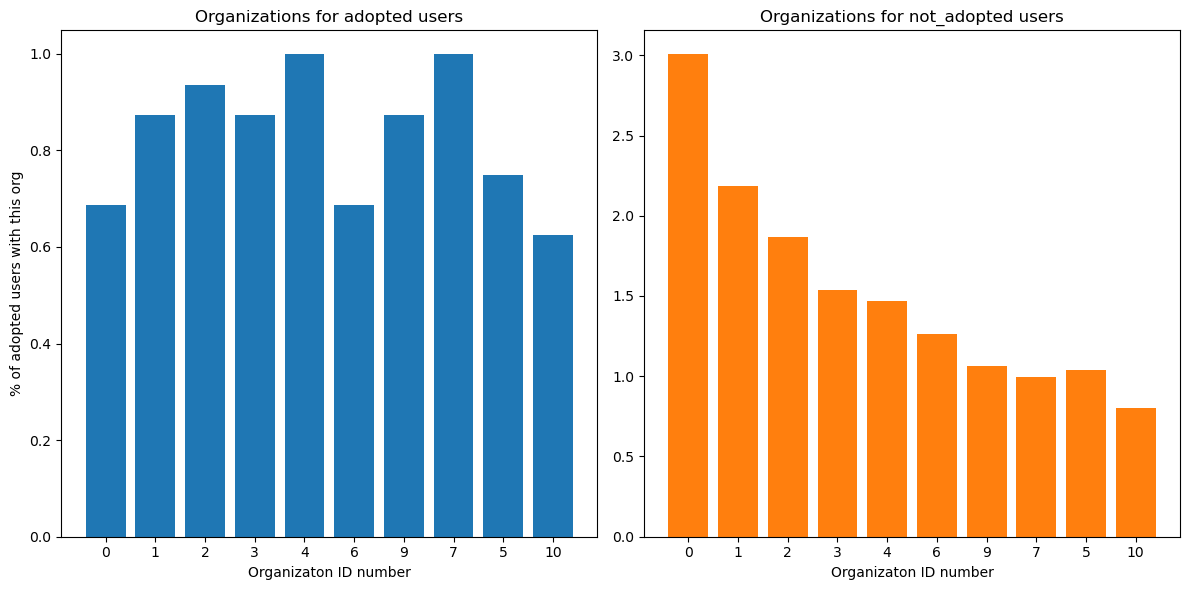

In [48]:
x_labels = organizations_list
y_values1 = adopted_percentages_list  # Y-axis values for the first bar chart
y_values2 = not_adopted_percentages_list  # Y-axis values for the second bar chart

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First bar chart
ax1.bar(organizations_list, adopted_percentages_list, color='Tab:blue')
ax1.set_title('Organizations for adopted users')
ax1.set_xlabel('Organizaton ID number')
ax1.set_ylabel('% of adopted users with this org')
ax1.set_xticks(organizations_list)

# Second bar chart
ax2.bar(organizations_list, not_adopted_percentages_list, color='Tab:orange')
ax2.set_title('Organizations for not_adopted users')
ax2.set_xlabel('Organizaton ID number')
ax1.set_ylabel('% of adopted users with this org')
ax2.set_xticks(organizations_list)

# Display the plot
plt.tight_layout()
plt.show()

Here we see the percentage of adopted and non-adopted users broken down by the organizations with the most members associated with them. 
No organization has a majority of either group. In fact, only a few of the top 10 organizations have more than a 1% share of adopted or not-adopted users. 
It does not seem like a specific organization is making the difference in user adoption.

# Modeling

In [49]:
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,last_session_creation_timestamp,time_between_creation_and_last_login
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,0,2014-04-22 03:53:30,0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,1,2014-03-31 03:45:04,136
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,0,2013-03-19 23:14:52,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,0,2013-05-22 08:09:28,1
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,0,2013-01-22 10:14:20,5


In [50]:
# drop ID column - not needed for modeling
users_df.drop(columns= ['object_id'], inplace = True)

## Extract creation_time features

In [51]:
#sign_up_date
#users_df['creation_year'] = users_df['creation_time'].dt.year
#users_df['creation_month'] = users_df['creation_time'].dt.month
#users_df['creation_day'] = users_df['creation_time'].dt.day

users_df.drop(columns= ['creation_time'], inplace = True)


#users_df['last_sign_in_year'] = users_df['last_session_creation_timestamp'].dt.year
#users_df['last_sign_in_year'] = users_df['last_session_creation_timestamp'].dt.month
#users_df['last_sign_in_year'] = users_df['last_session_creation_timestamp'].dt.day

users_df.drop(columns= ['last_session_creation_timestamp', 'last_session_creation_time'], inplace = True)

## Encode Categorical variables

In [52]:
users_df = pd.get_dummies(users_df, columns=['creation_source'], drop_first=True)

In [53]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8823 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   opted_in_to_mailing_list              8823 non-null   int64
 1   enabled_for_marketing_drip            8823 non-null   int64
 2   org_id                                8823 non-null   int64
 3   adopted_user                          8823 non-null   int64
 4   time_between_creation_and_last_login  8823 non-null   int64
 5   creation_source_ORG_INVITE            8823 non-null   bool 
 6   creation_source_PERSONAL_PROJECTS     8823 non-null   bool 
 7   creation_source_SIGNUP                8823 non-null   bool 
 8   creation_source_SIGNUP_GOOGLE_AUTH    8823 non-null   bool 
dtypes: bool(4), int64(5)
memory usage: 448.0 KB


In [54]:
X = users_df.drop('adopted_user', axis=1)  
y = users_df['adopted_user']

In [55]:
y.value_counts(normalize=True)

adopted_user
0    0.818429
1    0.181571
Name: proportion, dtype: float64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [57]:
#check that class imbalance is maintained using stratify for train test split
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


adopted_user
0    0.818697
1    0.181303
Name: proportion, dtype: float64

## Random Forest

In [63]:
# Create the Random Forest model
rf_baseline_model = RandomForestClassifier(random_state=42)  # You can adjust n_estimators

#generate cross_validation scores
rf_baseline_accuracy_scores = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='accuracy')
rf_baseline_f1_scores = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='f1')
rf_baseline_roc_auc_scores = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='roc_auc')
rf_baseline_precision = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='precision')
rf_baseline_recall = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='recall')

# Print the scores
print("Accuracy Scores:", rf_baseline_accuracy_scores)
print("F1 Scores:", rf_baseline_f1_scores)
print("ROC AUC Scores:", rf_baseline_roc_auc_scores)
print("Precision:", rf_baseline_precision)
print("Recall:", rf_baseline_recall)

Accuracy Scores: [0.96246459 0.9674221  0.96246459 0.95960312 0.9546421 ]
F1 Scores: [0.89708738 0.90980392 0.8962818  0.88247423 0.87351779]
ROC AUC Scores: [0.98897536 0.98130948 0.9884992  0.98285647 0.97758557]
Precision: [0.89534884 0.91699605 0.89803922 0.93449782 0.884     ]
Recall: [0.89883268 0.90272374 0.89453125 0.8359375  0.86328125]


## XGBoost

In [59]:
xgb_baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_baseline_accuracy_scores = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='accuracy')
xgb_baseline_f1_scores = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='f1')
xgb_baseline_roc_auc_scores = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='roc_auc')
xgb_baseline_precision = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='precision')
xgb_baseline_recall = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='recall')

# Print the scores
print("Accuracy Scores:", xgb_baseline_accuracy_scores)
print("F1 Scores:", xgb_baseline_f1_scores)
print("ROC AUC Scores:", xgb_baseline_roc_auc_scores)
print("Precision:", xgb_baseline_precision)
print("Recall:", xgb_baseline_recall)

Accuracy Scores: [0.96175637 0.95750708 0.95892351 0.95818568 0.95251595]
F1 Scores: [0.89534884 0.8828125  0.88582677 0.8788501  0.86732673]
ROC AUC Scores: [0.99005508 0.98981421 0.99215033 0.9892891  0.9870096 ]
Precision: [0.89189189 0.88627451 0.89285714 0.92640693 0.87951807]
Recall: [0.89883268 0.87937743 0.87890625 0.8359375  0.85546875]


## ADA Boost

In [61]:
# Base model for AdaBoost (usually a Decision Tree with a low max depth)
base_model = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost with the base model
ada_boost_baseline = AdaBoostClassifier(
    base_estimator=base_model, 
    n_estimators=100,           # Number of boosting rounds
    learning_rate=1.0,         # Controls the contribution of each classifier
    random_state=42            # Ensures reproducibility
)

In [62]:
adaboost_baseline_accuracy_scores = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='accuracy')
adaboost_baseline_f1_scores = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='f1')
adaboost_baseline_roc_auc_scores = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='roc_auc')
adaboost_baseline_precision = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='precision')
adaboost_baseline_recall = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='recall')

# Print the scores
print("Accuracy Scores:", adaboost_baseline_accuracy_scores)
print("F1 Scores:", adaboost_baseline_f1_scores)
print("ROC AUC Scores:", adaboost_baseline_roc_auc_scores)
print("Precision:", adaboost_baseline_precision)
print("Recall:", adaboost_baseline_recall)

Accuracy Scores: [0.96458924 0.96883853 0.96388102 0.95960312 0.95676825]
F1 Scores: [0.90310078 0.912      0.89820359 0.88295688 0.87824351]
ROC AUC Scores: [0.99081476 0.99126282 0.99281601 0.99048295 0.98805465]
Precision: [0.8996139  0.9382716  0.91836735 0.93073593 0.89795918]
Recall: [0.90661479 0.88715953 0.87890625 0.83984375 0.859375  ]


All these models are doing very well out of the box. I'm going to proceed with the XGBoost model below, but really any of them would seem to work. 
I just need a decent model so that I can look at the feature importances. I'm doing some tuning below but it's almost not needed given the baseline
performance. 

In [67]:
xgb_tuned_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

search_space = {
    'n_estimators':Integer(100,1500),
    'max_depth': Integer(0, 25),
    'scale_pos_weight': Integer(1,10),
    'eta': Real(0.1,0.9),
    'gamma':Real(0,3),
    'min_child_weight': Real(0,5),
    'subsample': Real(0,1),
    'lambda':  Real(1,10),
    'alpha':   Real(0,10)
}

bayes_search = BayesSearchCV(xgb_tuned_model, 
                             search_space, 
                             n_iter=50, 
                             cv=5, 
                             scoring= 'f1', 
                             verbose = 0, 
                             n_jobs=-1,
                             random_state=42)

bayes_search.fit(X_train, y_train)

best_params = bayes_search.best_params_

print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", bayes_search.best_score_)

Best Parameters: OrderedDict([('alpha', 10.0), ('eta', 0.9), ('gamma', 3.0), ('lambda', 10.0), ('max_depth', 0), ('min_child_weight', 0.0), ('n_estimators', 159), ('scale_pos_weight', 1), ('subsample', 0.2796366123124986)])
Best Score: 0.9052162907356692


# Test Set Performance

In [68]:
#Instantiate final model with best params
n_estimators_value = best_params['n_estimators']
max_depth_value = best_params['max_depth']
scale_pos_weight_value = best_params['scale_pos_weight']
eta_value = best_params['eta']
gamma_value = best_params['gamma']
min_child_weight_value = best_params['min_child_weight']
subsample_value = best_params['subsample']
lambda_value = best_params['lambda']
alpha_value = best_params['alpha']
 



xgb_final_model_best_params =XGBClassifier(
                                use_label_encoder=False, 
                                eval_metric='logloss',
                                n_estimators = n_estimators_value,
                                max_depth = max_depth_value,
                                scale_pos_weight  = scale_pos_weight_value,
                                eta = eta_value,
                                gamma = gamma_value,
                                min_child_weight = min_child_weight_value,
                                subsample = subsample_value,
                                reg_lambda = lambda_value,
                                reg_alpha = alpha_value 
                                )

In [69]:
#Train model with best params
xgb_final_model_best_params.fit(X_train, y_train)

#Predict on test set
y_pred_final= xgb_final_model_best_params.predict(X_test)
y_scores_rb_final = xgb_final_model_best_params.predict_proba(X_test)[:, 1]  # Probability of the positive class

In [70]:
# calculate optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_rb_final)

# Calculate F1 score for each threshold
beta = 1
fbeta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-10)  # Add a small constant to avoid division by zero

# Find the optimal threshold based on the maximum F0.3 score
optimal_idx = np.argmax(fbeta_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_fbeta = fbeta_scores[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Max F1 Score: {optimal_fbeta:.2f}')

Optimal Threshold: 0.74
Max F1 Score: 0.89


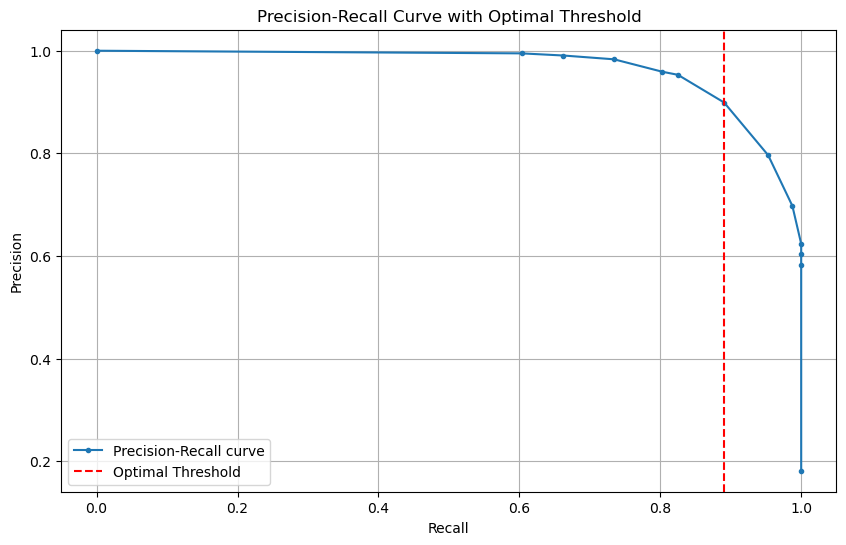

In [82]:
# Optional: Plot Precision-Recall curve with the optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.axvline(recall[optimal_idx], color='red', linestyle = '--',label='Optimal Threshold')
#plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label='Optimal Threshold')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()

In [73]:
# Apply optimal threshold to predicitons
y_pred_optimal = (y_scores_rb_final >= optimal_threshold).astype(int)

In [74]:
test_set_accuracy = accuracy_score(y_test, y_pred_optimal)
test_set_auc = roc_auc_score(y_test, y_pred_optimal)
test_set_f1 = f1_score(y_test, y_pred_optimal)


print(f'Accuracy on test set: {test_set_accuracy}')
print(f'AUC on test set: {test_set_auc}')
print(f'F1 on test set: {test_set_f1}')

Accuracy on test set: 0.9620396600566572
AUC on test set: 0.9342398356401383
F1 on test set: 0.8948194662480377


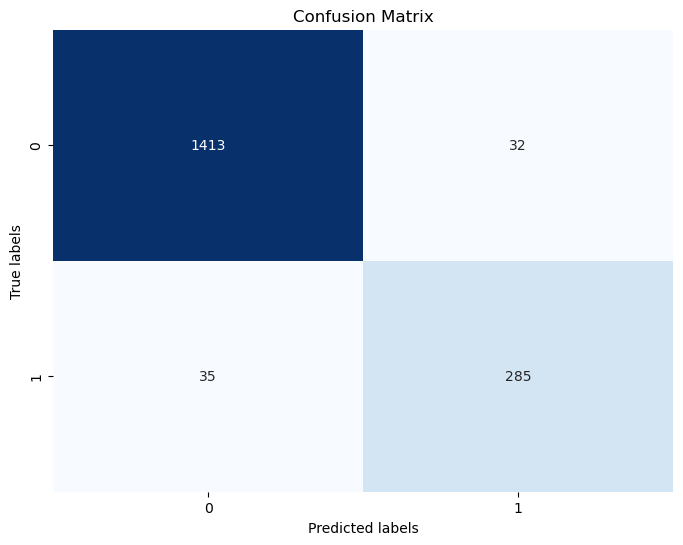

In [75]:
# Assuming y_test is your true labels and y_pred is the predicted labels
conf_mat = confusion_matrix(y_test, y_pred_optimal)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Feature importances

In [76]:
#Instantiate final model with best params
n_estimators_value = best_params['n_estimators']
max_depth_value = best_params['max_depth']
scale_pos_weight_value = best_params['scale_pos_weight']
eta_value = best_params['eta']
gamma_value = best_params['gamma']
min_child_weight_value = best_params['min_child_weight']
subsample_value = best_params['subsample']
lambda_value = best_params['lambda']
alpha_value = best_params['alpha']
 



xgb_final_model_best_params_all_data =xgb_final_model_best_params_all_data =XGBClassifier(
                                use_label_encoder=False, 
                                eval_metric='logloss',
                                n_estimators = n_estimators_value,
                                max_depth = max_depth_value,
                                scale_pos_weight  = scale_pos_weight_value,
                                eta = eta_value,
                                gamma = gamma_value,
                                min_child_weight = min_child_weight_value,
                                subsample = subsample_value,
                                reg_lambda = lambda_value,
                                reg_alpha = alpha_value 
                                )

xgb_final_model_best_params_all_data.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.9, eval_metric='logloss',
              feature_types=None, gamma=3.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
              max_leaves=None, min_child_weight=0.0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=159,
              n_jobs=None, num_parallel_tree=None, ...)

In [77]:
# Retrieve feature importances
importances = xgb_final_model_best_params_all_data.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

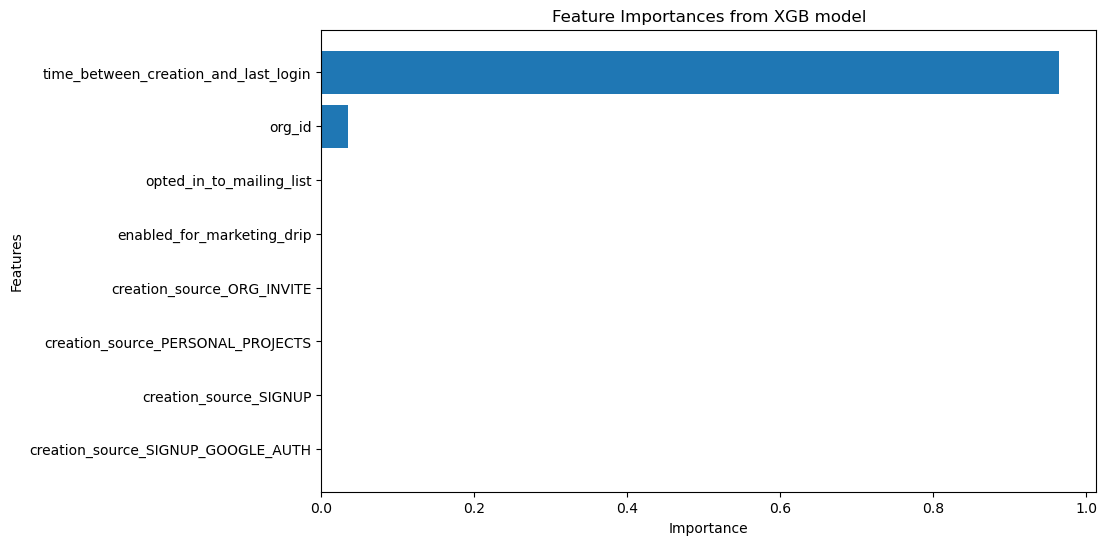

In [78]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from XGB model')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

[21:21:20] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_d6q0e1lomi/croot/xgboost-split_1713972719224/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


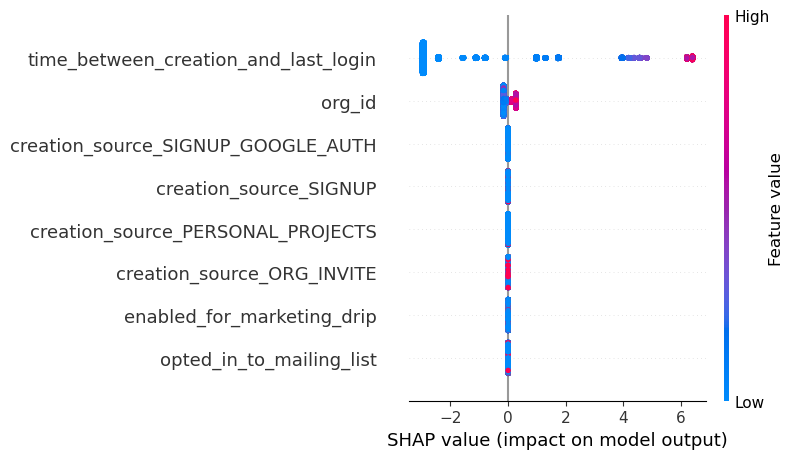

In [79]:
# Create SHAP values
explainer = shap.TreeExplainer(xgb_final_model_best_params_all_data)  # For tree-based models
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot (feature importances)
shap.summary_plot(shap_values, X)  # Bar plot for importance ranking

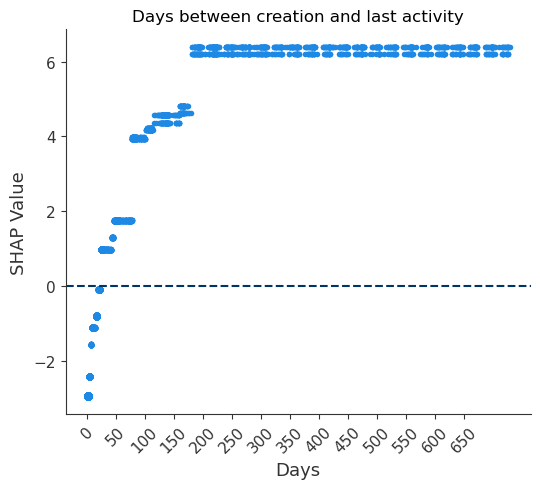

In [80]:
shap.dependence_plot('time_between_creation_and_last_login', shap_values, X, show = False, interaction_index=None)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line

# Add a title to the plot
ax.set_title('Days between creation and last activity')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Days')
ax.set_ylabel('SHAP Value')

custom_ticks = list(range(1,200,25))  # Replace with your desired x-tick values

# Define custom x-ticks and apply rotation
custom_ticks = list(range(0, 700, 50))
ax.set_xticks(custom_ticks)
plt.xticks(rotation=45)

# Show the plot
plt.show()

The major takeaway here seems to be that the best predictor for wheter a person becomes an adopted user or not is how long has elapsed between their account creation date
and their last log in date. 

This can be thought of as a proxy for time on the platform. 

So given the data available, the factor that best predicts future user adoption is how long they have been using the platform. 